# Test: reading nclimgrid gridded precipitation

This test is designed to read a small number of days of nclimgrid 4 data and compare the raw nclimgrid gridded data to the values that end up in the SWB model. There are many ways that incorrect values can be read from netCDF and make their way into a SWB calculation. Therefore, it is important to verify that the nclimgrid grid is being read in correctly and that the values from nclimgrid end up in the proper SWB grid cell.

This notebook is organized into two sections: 'test setup' and 'test comparisons'. To make the comparison, a test grid centered on the state of Minnesota is created, and SWB is run for a 14-day period. Only a short simulation is needed to verify that the nclimgrid netCDF file contents are read in and distributed to the proper SWB gridcells.

The strategy for comparison is straighforward. Pyproj is used to establish coordinate reference systems (CRS) for the nclimgrid dataset and the SWB grid. nclimgrid uses a Lambert Conformal Conic projection, while the SWB grid uses an Albert Equal Area projection (EPSG 5070). First, a random sample of x and y coordinates is pulled from the SWB grid. Values corresponding to the SWB coordinates are pulled from the SWB output grid. The SWB grid coordinates are transformed using Pyproj from the SWB grid CRS to the nclimgrid grid CRS. The values nearest to the generated nclimgrid coordinates are then extracted from the nclimgrid grid. If the SWB code is properly performing a nearest-neighbor search, the SWB grid results (as read in) and the nclimgrid grid results (extracted as described) should be identical.

## Test setup

In [1]:
import xarray as xr
import pathlib as pl
import pyproj as pp
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import sys
import random as rnd

#### Define paths to swb2 executable and working/input data directories

In [2]:
# define working directories for use in making a forward run of SWB2
base_dir = str(pl.Path.cwd().parent)
python_script_dir = pl.Path.cwd().parent / 'python'
swb_work_dir = 'test__netcdf_nclimgrid'
logfile_dir = 'logfiles'
test_data_dir = pl.Path.cwd().parent / 'test_data'
output_dir = 'output'
swb2_executable = str(pl.Path.cwd().parent / 'bin' /'swb2.exe')
sys.path.append(str(python_script_dir))

import run_management as rm

#### Remove and replace working directories for swb2 run

In [3]:
rm.destroy_model_work_output_and_logfile_dirs(base_dir=base_dir,
                                              swb_work_dir=swb_work_dir,
                                              logfile_dir=logfile_dir,
                                              output_dir=output_dir)
rm.create_model_work_output_and_logfile_dirs(base_dir=base_dir,
                                             swb_work_dir=swb_work_dir,
                                             logfile_dir=logfile_dir,
                                             output_dir=output_dir)

#### Make a new swb2 model run for an example area

In the following step, a new swb2 model run is started using a pre-configured swb control file. The test case is centered on the state of Minnesota. The swb model contains 620 cells in the x direction and 688 cells in the y direction. For this test, a tiny subset of the nclimgrid weather data is being used. The nclimgrid grids have been subsetted to cover a spatial extent slightly larger than the extent of the SWB grid; in addition, only 14 timesteps are retained in order to make the comparison files as small as possible.

In [4]:
dry_run = False
lookup_dir_arg_text = f"--lookup_dir={str(test_data_dir)}"
weather_data_dir_arg_text = f"--weather_data_dir={str(test_data_dir)}"
data_dir_arg_text = f"--data_dir={str(test_data_dir)}"
output_dir_arg_text = f"--output_dir={str(output_dir)}"
logfile_dir_arg_text = f"--logfile_dir={str(logfile_dir)}"
control_file_path = str(test_data_dir / 'swb_control_file_nclimgrid.ctl')
output_prefix = '--output_prefix=swb_nclimgrid_test_'

swb_arg_text = [swb2_executable, output_dir_arg_text, lookup_dir_arg_text, weather_data_dir_arg_text, 
                data_dir_arg_text, output_prefix, logfile_dir_arg_text, control_file_path]

f = open("stdout.txt", "w")

if not dry_run:
  with rm.cd(pl.Path(base_dir) / swb_work_dir):
#    p = subprocess.Popen(swb_arg_text, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    p = subprocess.Popen(swb_arg_text, stdout=f, stderr=subprocess.DEVNULL)
    p.wait()

In [5]:
# define CRS for nclimgrid and SWB grids
crs_cg = pp.CRS.from_epsg(4326)
crs_swb = pp.CRS.from_epsg(5070)

In [6]:
df_cg = xr.open_dataset(test_data_dir / 'nclimgrid-prcp-200001-grd-scaled_mn__14-day.nc')
df_swb = xr.open_dataset( pl.Path(base_dir).resolve() / swb_work_dir / output_dir / 
                         "swb_nclimgrid_test_gross_precipitation__2000-01-01_to_2000-01-14__680_by_620.nc")

da_cg = df_cg.to_dataarray()
da_swb = df_swb.to_dataarray()

In [7]:
# use pyproj to determine the coordinate values in the nclimgrid data set based on the subset pulled from the SWB grid
proj = pp.transformer.Transformer.from_crs(crs_swb, crs_cg, always_xy=True)

In [8]:
def get_random_val(drange):
    v = rnd.randrange(start=int(drange*.1), stop=int(drange*.9))
    return v

#### Generate a set of coordinate values for data extraction and comparison

In this step, a random set of xy values is drawn from the SWB grid. These are transformed into another set of xy values that specifies the nearest location in terms of the nclimgrid CRS. 

In [9]:
number_of_xy_pairs = 30
xrange = df_swb.sizes['x']
yrange = df_swb.sizes['y']
x_indices = [get_random_val(xrange) for i in range(number_of_xy_pairs)]
y_indices = [get_random_val(yrange) for i in range(number_of_xy_pairs)]
x_swb = da_swb.x.values[x_indices]
y_swb = da_swb.y.values[y_indices]
x_cg, y_cg = proj.transform(x_swb, y_swb)

#### Create subset of SWB and nclimgrid values

In this step, the values contained in the SWB output file are extracted for the subset of SWB xy values. The corresponding values are also extracted from the nclimgrid grid files using the subset of nclimgrid grid xy values. The extracted values are stored in separate lists.

In [10]:
swb_vals = []
nclimgrid_vals = []

for i in range(number_of_xy_pairs):
    data_cg = df_cg.sel(lon=x_cg[i], lat=y_cg[i], method='nearest')
    data_swb = df_swb.sel(x=x_swb[i],y=y_swb[i], method='nearest')
    pdm = list(data_cg.prcp.values)
    pswb = list(data_swb.gross_precipitation.values*25.4)
    for item in pswb:
        swb_vals.append(item)
    for item in pdm:
        nclimgrid_vals.append(item)
    

#### Create Pandas dataframe from lists

In [11]:
results_df = pd.DataFrame(data={'swb_precip': swb_vals,'nclimgrid_precip': nclimgrid_vals})

#### Drop NaN values from the dataframe of results

Generally, there are many areas within a SWB grid that might be inactive. These areas might be over open water, or cover parts of the model domain for which no data exist. Here we drop all rows from the dataframe that contain 'NaN' values. 

In [12]:
# dropping 'NaN' values, since these likely exist owing to inactive model cells within the SWB grid
results_df.dropna(axis=0, inplace=True)

## Test comparisons

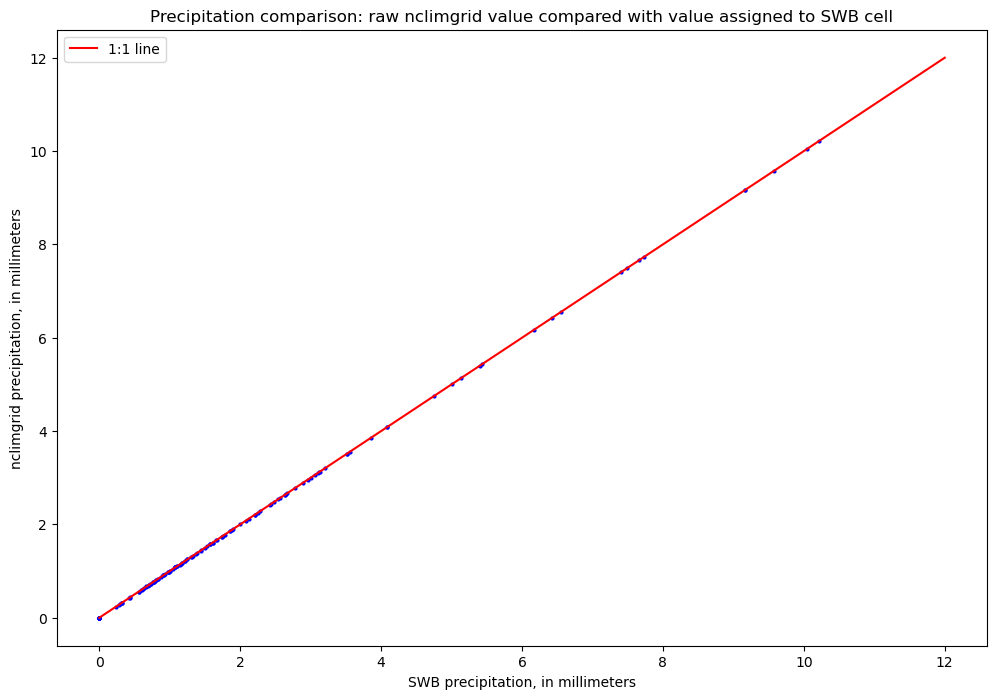

In [13]:
fig, ax = plt.subplots(1,1,figsize=(12, 8),sharex=False)
ax.plot(results_df['swb_precip'], results_df['nclimgrid_precip'], marker='.', linestyle=' ', color='blue', markersize=4)
ax.plot(range(13), range(13), linestyle='-', color='red', label='1:1 line')
ax.set_ylabel('nclimgrid precipitation, in millimeters')
ax.set_xlabel('SWB precipitation, in millimeters')
ax.set_title('Precipitation comparison: raw nclimgrid value compared with value assigned to SWB cell')
ax.legend()